In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
def compute_curvature(p0, p1, p2):
    # p0, p1, p2 are (x, y) points
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = p2

    # Circle fitting curvature formula
    denom = (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    if abs(denom) < 1e-6:
        return 0.0
    num = 2 * ((x1 - x2)*(y1 - y3) - (y1 - y2)*(x1 - x3))
    curvature = num / denom
    return curvature

In [3]:
def relative_distance(p1, p2):
        return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

In [4]:
def simulate_agent(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_decel=4.0, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.
    
    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.5
    mu = 0.8
    g = 9.81

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        # Target waypoint
        target_x, target_y = waypoints[i]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta


        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error
        # desired_steering *= (1 + 0.5 * (max_speed - sim_speed) / max_speed)
        

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        # desired_accel *= max(1.0, 1.0 - abs(clipped_steering) / max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)


        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

    return low_level_actions, dreamed_waypoints

In [5]:
def simulate_agent_lookahead(waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.
    
    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = 0
    sim_y = 0
    sim_heading = 0
    sim_vx = speed_init
    sim_vy = 0
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        # Target waypoint
        target_idx = i + 0
        if target_idx >= num_waypoints:
            target_idx = num_waypoints - 1

        inter = target_idx - i + 1
        target_x = waypoints[target_idx][0]
        target_y = waypoints[target_idx][1]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / (time_delta * inter)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Speed-dependent steering reduction
        # speed_factor = max(0.1, 1.0 - sim_speed / 50.0)
        # desired_steering *= speed_factor

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)


        # Avoid going backwards if target is behind
        forward_x = math.cos(sim_heading)
        forward_y = math.sin(sim_heading)

        # Vector from vehicle to target
        to_target_x = target_x - sim_x
        to_target_y = target_y - sim_y

        # Dot product
        dot = forward_x * to_target_x + forward_y * to_target_y

        # If target is behind, override actions
        if dot < 0.0:
            clipped_accel = -4
            clipped_steering = 0          

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

    return low_level_actions, dreamed_waypoints

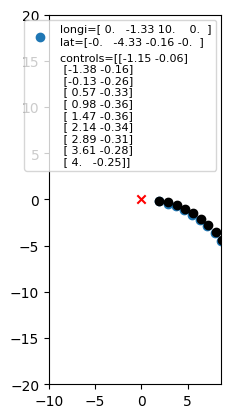

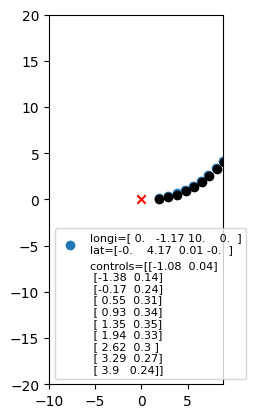

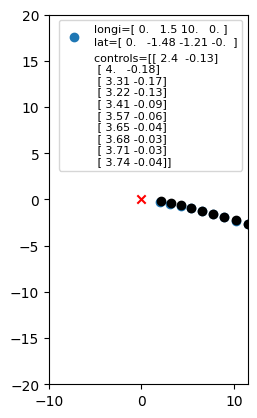

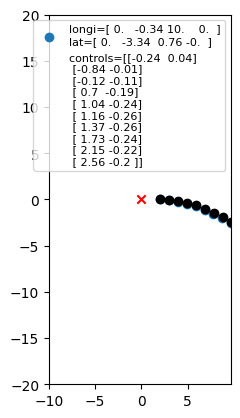

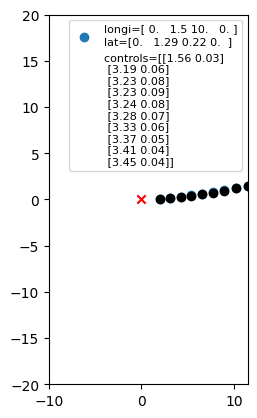

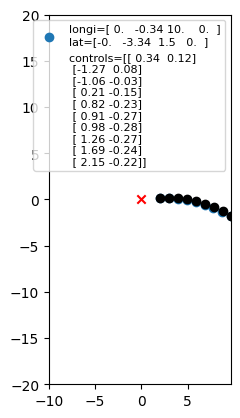

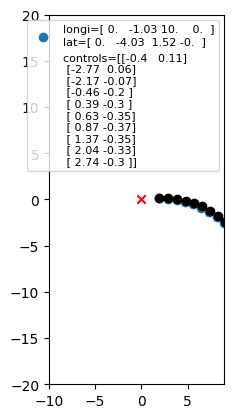

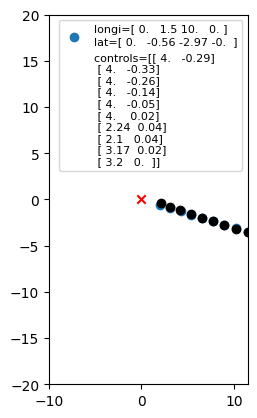

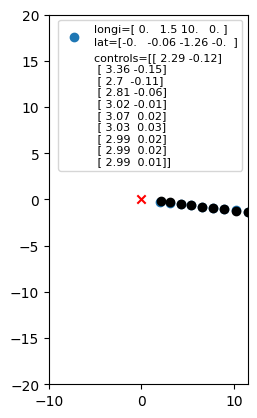

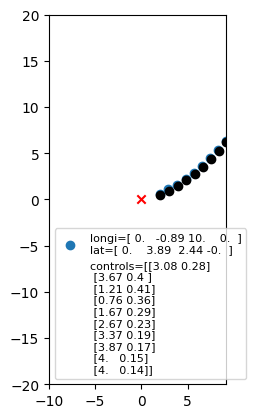

In [6]:
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
veh_speed = 10
current_pos = 0, 0, 0, veh_speed, 0  # x, y, heading, vx, vy
USE_LOOKAHEAD = False
for _ in range(10):
    coeffs_longi = [random.uniform(1, 1) for _ in range(4)]
    coeffs_longi[0] *= 0 # c3
    coeffs_longi[1] *= 1.5 # c2
    coeffs_longi[2] = veh_speed # + coeffs_longi[2] * 0.1# c1
    coeffs_longi[3] *= 0 # c0

    coeffs_lat = [random.uniform(-1, 1) for _ in range(4)]
    coeffs_lat[0] *= 0.0
    coeffs_lat[1] *= 5.0 # c2 10
    coeffs_lat[2] *= 3.0 # c1 3
    coeffs_lat[3] *= 0 # c0
    # coeffs_lat[2] = min(coeffs_lat[2], 0.1 * veh_speed) # min(1, coeffs_longi[1])  # <-- note: this line ties lateral slope to longitudinal
    # coeffs_longi[1] -= 0.1 * coeffs_lat[2] 

    max_longi_acc = 3 - 1 * abs(coeffs_lat[1])
    coeffs_longi[1] = np.clip(coeffs_longi[1], -max_longi_acc, max_longi_acc)

    # Evaluate polynomials
    longi_traj = np.polyval(coeffs_longi, t_values)
    lateral_traj = np.polyval(coeffs_lat, t_values)

    # Stack waypoints
    local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1)
    local_waypoints = local_waypoints[1:] + np.array([current_pos[0], current_pos[1]])
    # local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1) + np.array([current_pos[0], current_pos[1]])

    # local_waypoints = local_waypoints[1:]
    if USE_LOOKAHEAD:
        control_actions, dreamed_waypoints = simulate_agent_lookahead(local_waypoints, num_waypoints=len(t_values)-1, speed_init=veh_speed)
    else:
        control_actions, dreamed_waypoints = simulate_agent(current_pos, local_waypoints, num_waypoints=len(t_values)-1, speed_init=veh_speed)
    dreamed_waypoints = np.array(dreamed_waypoints)
    control_actions = np.array(control_actions)
    control_actions = control_actions

    # Plot
    plt.scatter(local_waypoints[1:, 0], local_waypoints[1:, 1],
                label=f"longi={np.round(coeffs_longi,2)}\nlat={np.round(coeffs_lat,2)}")

    plt.scatter(dreamed_waypoints[1:, 0], dreamed_waypoints[1:, 1], c='black', marker='o')
    plt.plot([], [], ' ', label=f"controls={np.round(control_actions,2)}")
    # --- Keep (0,0) at the center ---
    max_range = np.max(np.abs(local_waypoints))
    plt.xlim(-10, max_range)
    plt.ylim(-20, 20)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.scatter(0, 0, c='red', marker='x')
    plt.legend(fontsize=8, loc="best")
    plt.show()


In [7]:
local_waypoints

array([[0.99112031, 0.28322249],
       [1.96448124, 0.64420435],
       [2.92008278, 1.0829456 ],
       [3.85792494, 1.59944624],
       [4.77800772, 2.19370625],
       [5.68033112, 2.86572565],
       [6.56489514, 3.61550443],
       [7.43169977, 4.44304259],
       [8.28074502, 5.34834013],
       [9.11203089, 6.33139706]])

In [8]:
num_waypoints = 10
t_values = np.linspace(0, 1, num_waypoints + 1)
t_values

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
local_waypoints

array([[0.99112031, 0.28322249],
       [1.96448124, 0.64420435],
       [2.92008278, 1.0829456 ],
       [3.85792494, 1.59944624],
       [4.77800772, 2.19370625],
       [5.68033112, 2.86572565],
       [6.56489514, 3.61550443],
       [7.43169977, 4.44304259],
       [8.28074502, 5.34834013],
       [9.11203089, 6.33139706]])

In [10]:
dreamed_waypoints

array([[1.02043042, 0.14579505],
       [2.0424765 , 0.45412212],
       [3.02603426, 0.89934777],
       [3.96601609, 1.44580374],
       [4.87513402, 2.07205702],
       [5.76489964, 2.76960229],
       [6.64077232, 3.5366683 ],
       [7.50371278, 4.37476993],
       [8.35046451, 5.28467532],
       [9.1769703 , 6.26591954]])

### SIMULATE RL ENV CONTROL AND TRAJ

In [151]:
def simulate_agent_control(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.
    
    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        target_x = waypoints[i][0]
        target_y = waypoints[i][1]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        # dx = target_x - sim_x
        # dy = target_y - sim_y
        # desired_yaw = math.atan2(dy, dx)
        if i != num_waypoints - 1:
            target_xp = waypoints[i + 1][0]
            target_yp = waypoints[i + 1][1]
            dxp = target_xp - target_x
            dyp = target_yp - target_y
            desired_yaw = math.atan2(dyp, dxp)
        else:
            dx = target_x - sim_x
            dy = target_y - sim_y
            desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

        if i == 0:
            next_pos = sim_x, sim_y, sim_heading, sim_vx, sim_vy

    return low_level_actions, dreamed_waypoints, next_pos

[[0.4987562112088817, 0.29145679447786715], [3.552713678800501e-14, 0.2914567944778671], [0.0, 0.29145679447786715], [0.0, 0.2914567944778669], [1.7763568394002505e-14, 0.2914567944778674], [-5.3290705182007514e-14, 0.2914567944778673], [5.3290705182007514e-14, 0.2914567944778673], [-7.105427357601002e-14, 0.2914567944778669], [3.552713678800501e-14, 0.2914567944778679], [-8.881784197001252e-14, 0.29145679447786643]]


/tmp/ipykernel_76719/2599026049.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="best")


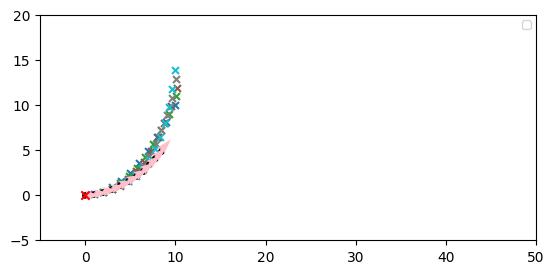

In [152]:
# Temporal succession of control and steps
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
veh_speed = 10
USE_LOOKAHEAD = False

controlled_waypoints = []
pred_trajectories = []
current_pos = 0, 0, 0, veh_speed, 0  # x, y, heading, vx, vy
chosen_actions = []
# Simulate 5 actions with same trajectory predicted
headings = []
headings.append(current_pos[2])
for i in range(10):

    coeffs_longi = [random.uniform(-1, 1) for _ in range(4)]
    coeffs_longi[0] = 0.0 # c3
    coeffs_longi[1] = 0.0 # c2
    coeffs_longi[2] = veh_speed # c1
    coeffs_longi[3] = 0 # c0
    

    coeffs_lat = [random.uniform(-1, 1) for _ in range(4)]
    coeffs_lat[0] *= 0
    coeffs_lat[1] = 10.0 # c2 10
    coeffs_lat[2] = 0 # c1 3
    coeffs_lat[3] *= 0 # c0

    # max_longi_acc = 3 - 1 * abs(coeffs_lat[1])
    # coeffs_longi[1] = np.clip(coeffs_longi[1], -max_longi_acc, max_longi_acc)

    # Evaluate polynomials
    longi_traj = np.polyval(coeffs_longi, t_values)
    lateral_traj = np.polyval(coeffs_lat, t_values)

    # Stack waypoints
    # Extract vehicle position and heading
    current_x, current_y, current_heading, _, _ = current_pos  # assuming [x, y, yaw]
    local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1)
    local_waypoints = local_waypoints[1:] # + np.array([current_x, current_y])
    # pred_trajectories.append(local_waypoints)

    # Rotation matrix (2x2)
    cos_h = np.cos(current_heading)
    sin_h = np.sin(current_heading)
    R = np.array([[cos_h, -sin_h],
                [sin_h,  cos_h]])

    # Apply transform: rotate then translate
    global_waypoints = (R @ local_waypoints.T).T + np.array([current_x, current_y])

    # Store trajectory in global frame
    pred_trajectories.append(global_waypoints)

    control_actions, dreamed_waypoints, current_pos = simulate_agent_control(current_pos, global_waypoints, kp_steering=1.0, 
                                                                             num_waypoints=len(t_values)-1, speed_init=veh_speed)

    controlled_waypoints.append(dreamed_waypoints[0])
    chosen_actions.append(control_actions[0])
    headings.append(current_pos[2])
    

colors = plt.cm.tab10(np.linspace(0, 1, 5))  # 5 distinct colors from the "tab10" colormap
print(chosen_actions)
for i in range(5):
    plt.scatter(pred_trajectories[i][:, 0], pred_trajectories[i][:, 1],
                color=colors[i], marker='x', s=25)
    # plt.text(pred_trajectories[i][:, 0][9], pred_trajectories[i][:, 1][9], str(i), fontsize=10, color='red')


controlled_waypoints = np.array(controlled_waypoints)
controlled_waypoints = np.vstack(([0, 0], controlled_waypoints))

plt.scatter(controlled_waypoints[:, 0], controlled_waypoints[:, 1], c='black', marker='o', s=15.0)

# Plot headings as arrows (unit vectors from angle in radians)
headings = np.array(headings)  # assuming same length as controlled_waypoints
dx = np.cos(headings)
dy = np.sin(headings)

plt.quiver(controlled_waypoints[:, 0], controlled_waypoints[:, 1],
           dx, dy, angles='xy', scale_units='xy', scale=0.6, color='pink')
# print(control_actions)
# --- Keep (0,0) at the center ---
max_range = np.max(np.abs(local_waypoints))
plt.xlim(-5, 50)
plt.ylim(-5, 20)
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis("equal")
plt.scatter(0, 0, c='red', marker='x')
plt.legend(fontsize=8, loc="best")
plt.show()